# Hate Speech Detector - EN - SVM model

Based on [this notebook](https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/classifier/final_classifier.ipynb).

In [1]:
import os
import pandas as pd
import csv
import glob
import numpy as np
import pickle
from klepto.archives import dir_archive

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

## Load features & labels

In [2]:
archive = dir_archive('hsd/DavidsonEtAl/X_y_svm', {}, cached=True)
archive.load()

features = archive['features']
labels = archive['labels']

In [3]:
features.shape

(24783, 267)

## Model

The best model was selected using a GridSearch with 5-fold CV.

In [4]:
# dimensions reduction
select = SelectFromModel(LogisticRegression(class_weight='balanced', penalty="l1", C=0.01))
feat_ = select.fit_transform(features, labels)

/home/jakub/Dokumenty/VirtualEnv/local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [5]:
# linear svm classifier
model = LinearSVC(class_weight='balanced', C=0.01, penalty='l2', loss='squared_hinge', multi_class='ovr').fit(feat_, labels)

/home/jakub/Dokumenty/VirtualEnv/local/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [6]:
# logistic regression classifier
model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.01).fit(feat_, labels)

In [7]:
# predictions
y_preds = model.predict(feat_)

## Visualizations

In [8]:
def confusion_matrix_plot(conf_mat, cls, x_label, y_label, title, file_name=None):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.grid(False)
    plt.xticks(tick_marks, cls, rotation=45)
    plt.yticks(tick_marks, cls)
    
    for i in range(len(cls)):
        for j in range(len(cls)):
            plt.text(j - 0.2, i, str(conf_mat[i][j]), fontsize=16)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def class_distribution_hist(y_true, y_pred, cls, x_label, y_label, title, file_name=None):
    pd.Series([y_true, y_pred]).hist()
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.xticks(tick_marks, cls)
    plt.legend(labels=['Real', 'Predicted'], loc='best')
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

In [9]:
report = classification_report(labels, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.95      0.78      4163
           1       0.99      0.90      0.94     20620

   micro avg       0.91      0.91      0.91     24783
   macro avg       0.83      0.93      0.86     24783
weighted avg       0.93      0.91      0.92     24783



In [10]:
classes = ['no hate', 'hate']
conf_mat = confusion_matrix(labels, y_preds)
conf_mat_perc = np.array([[round(float(it)/np.sum(row), 2) for it in row] for row in conf_mat])
acc = float(np.sum(np.diag(conf_mat)))/np.sum(np.sum(conf_mat))

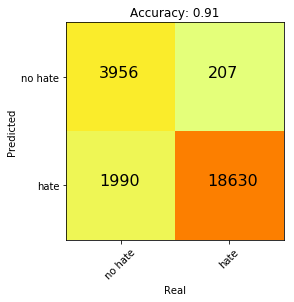

In [11]:
confusion_matrix_plot(conf_mat, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='Accuracy: {}'.format(round(acc, 2)),
                      file_name='results/en_svm/cm.png')

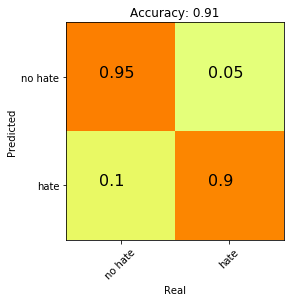

In [12]:
confusion_matrix_plot(conf_mat_perc, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='Accuracy: {}'.format(round(acc, 2)),
                      file_name='results/en_svm/frac_cm.png')

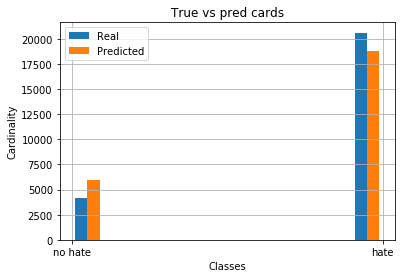

In [13]:
class_distribution_hist(labels, y_preds, cls=classes,
                        x_label='Classes', y_label='Cardinality', title='True vs pred cards',
                        file_name='results/en_svm/cards.png')

## Training with 70% & testing with 30%

In [14]:
X__train = feat_[:int(0.7*len(feat_))]
y_train = labels[:int(0.7*len(labels))]
X__test = feat_[int(0.7*len(feat_)):]
y_test = labels[int(0.7*len(labels)):]

print('Train X: {}'.format(len(X__train)))
print('Train y: {}'.format(len(y_train)))
print('Test X: {}'.format(len(X__test)))
print('Test y: {}'.format(len(y_test)))

Train X: 17348
Train y: 17348
Test X: 7435
Test y: 7435


In [15]:
# linear svm classifier
partial_model = LinearSVC(class_weight='balanced', C=0.01, penalty='l2', loss='squared_hinge', multi_class='ovr').fit(X__train, y_train)

In [16]:
# logistic regression classifier
partial_model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.01).fit(X__train,y_train)

In [17]:
# predictions
partial_y_preds = partial_model.predict(X__test)

## Visualizations

In [18]:
report = classification_report(y_test, partial_y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.96      0.78      1237
           1       0.99      0.90      0.94      6198

   micro avg       0.91      0.91      0.91      7435
   macro avg       0.82      0.93      0.86      7435
weighted avg       0.93      0.91      0.91      7435



In [19]:
part_conf_mat = confusion_matrix(y_test, partial_y_preds)
part_conf_mat_perc = np.array([[round(float(it)/np.sum(row), 2) for it in row] for row in part_conf_mat])
acc = float(np.sum(np.diag(part_conf_mat)))/np.sum(np.sum(part_conf_mat))
f1s0 = 2*float(part_conf_mat[0][0])/(2*float(part_conf_mat[0][0]) + part_conf_mat[0][1] + part_conf_mat[1][0])
f1s1 = 2*float(part_conf_mat[1][1])/(2*float(part_conf_mat[1][1]) + part_conf_mat[1][0] + part_conf_mat[0][1])

In [20]:
if not os.path.exists('results/en_svm/short_results.csv'):
    with open('results/en_svm/short_results.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Accuracy', 'F1 score (0)', 'F1 score (1)'])
        writer.writerow([acc, f1s0, f1s1])
else:
    with open('results/en_svm/short_results.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([acc, f1s0, f1s1])

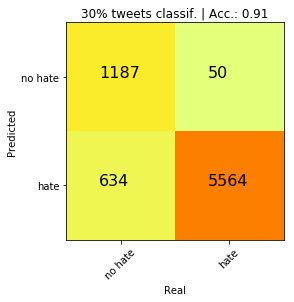

In [21]:
confusion_matrix_plot(part_conf_mat, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='30% tweets classif. | Acc.: {}'.format(round(acc, 2)),
                      file_name='results/en_svm/cm_30p.png')

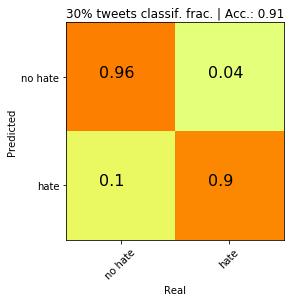

In [22]:
confusion_matrix_plot(part_conf_mat_perc, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='30% tweets classif. frac. | Acc.: {}'.format(round(acc, 2)),
                      file_name='results/en_svm/frac_cm_30p.png')

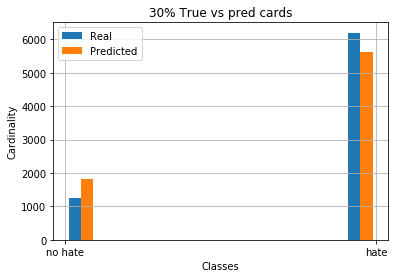

In [23]:
class_distribution_hist(y_test, partial_y_preds, cls=classes,
                        x_label='Classes', y_label='Cardinality', title='30% True vs pred cards',
                        file_name='results/en_svm/cards_30p.png')

In [24]:
with open('hsd/DavidsonEtAl/perfect_data.pkl', 'r') as f:
    texts, _ = pickle.load(f)
texts = texts[int(0.7*len(texts)):]

indices = [6, 10, 19, 26, 27, 28, 29, 164]
test_cases = []
for i, (t, p, l) in enumerate(zip(texts, partial_y_preds, y_test)):
    if i in indices:
        test_cases.append({'Text': t, 'Prediction': p, 'Label': l})

In [25]:
def test_cases_board(test_cases, title, file_name=None):
    h = 20
    n = len(test_cases)
    fig, axis = plt.subplots(1, 1, figsize=(16., n*3.2))
    axis.axis('off')
    axis.set_xlim([0, 100])
    axis.set_ylim([0, n*h])
    axis.plot([0, 100], [0, 0], color='k')
    axis.plot([0, 0], [0, n*h], color='k')
    axis.plot([100, 100], [0, n*h], color='k')
    
    for i in range(n):
        axis.annotate('Tweet text:', xy=(4, 16 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        text = u'{}'.format(test_cases[i]['Text'].decode('utf-8').replace('\n', ''))
        text = '\n'.join([text[j:j+len(text)/3] for j in range(0, len(text), len(text)/3)])
        axis.annotate(text, xy=(4, 7 + i*h), xycoords='data', size=15)
        
        axis.annotate('Prediction:', xy=(4, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        pred = 'no hate' if test_cases[i]['Prediction'] == 0 else 'hate speech'
        pred_color = 'b' if pred == 'no hate' else 'm'
        axis.annotate(pred, xy=(15, 4 + i*h), xycoords='data', size=15, color=pred_color)
        
        axis.annotate('Label:', xy=(27, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        label = 'no hate' if test_cases[i]['Label'] == 0 else 'hate speech'
        label_color = 'b' if label == 'no hate' else 'm'
        axis.annotate(label, xy=(34, 4 + i*h), xycoords='data', size=15, color=label_color)
        
        axis.annotate('Result:', xy=(50, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        reason = 'OK' if pred == label else '1-st type error' if pred == 'no hate' else '2-nd type error'
        reason_color = 'g' if reason == 'OK' else 'r'
        axis.annotate(reason, xy=(57, 4 + i*h), xycoords='data', size=15, color=reason_color)
        
        axis.plot([0, 100], [20 + i*h, 20 + i*h], color='k')
    
    
    plt.title(title)
    if file_name:
        plt.savefig(file_name)
    plt.show()

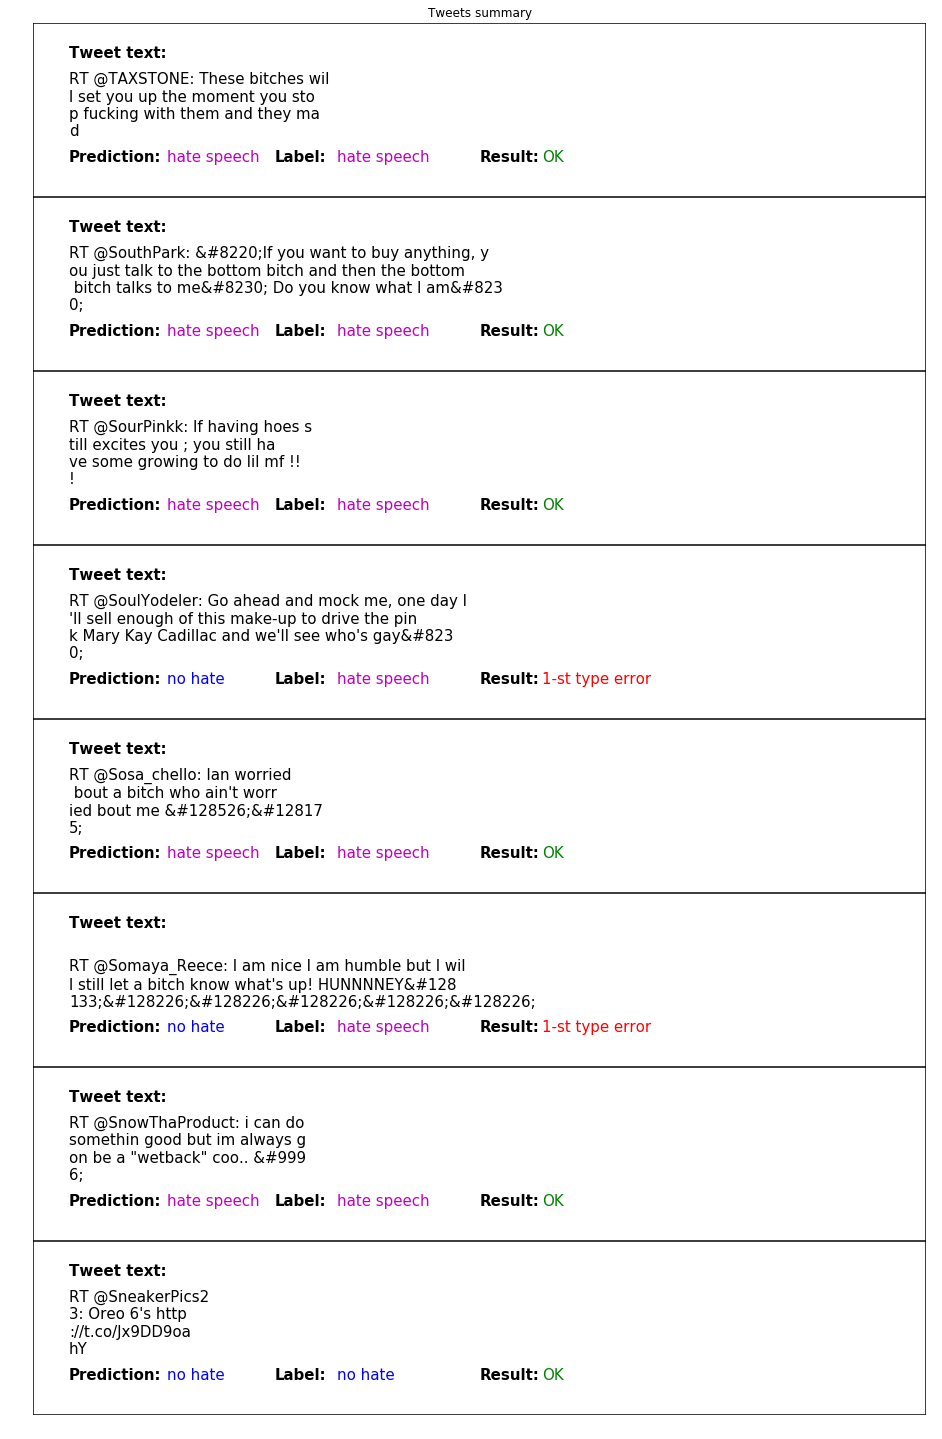

In [26]:
test_cases_board(test_cases, title='Tweets summary', file_name='results/en_svm/tweets_summary.png')

# Hate Speech Detector - EN - SVM model testing

## Load test features, predict classes, assign tweets and save to .csv

In [ ]:
with open('tests/en_svm/assigned_labels.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Label'])
    
    t = tqdm(sorted(glob.glob('tests/en_svm/X*')))
    for file_name in t:
        t.set_postfix_str(file_name)
        archive = dir_archive(file_name, {}, cached=True)
        archive.load()

        test_features = archive['features']
        
        test_feat_ = select.transform(test_features)
        test_preds = model.predict(test_feat_)
        
        for tp in test_preds:
            writer.writerow([tp])